# Intro

In this tutorial, we showcase how ARGEN can be applied to Perturb-seq datasets and reproduce key results in the manuscirpt.

# Arguments and set up

To run the codes, **(i)** designate the directory, where ARGEN was cloned from the Github repository, **(ii)** number of CPU cores to be used for parallel jobs, **(iii)** the significance level $\alpha$ for descendant set search and the parent set search and **(iv)** index of chromosome to be analyzed. e.g., if chromosome 6 is analyzed, type in 6.

In [ ]:
DIR='/kmp0223/ARGEN/'
ncores=10
alpha_desc=alpha_IV = 0.05
chr=6

Set up options and directories to run the codes.

In [ ]:
options(future.globals.maxSize = 10 * 1024^3) 
set.seed(1)
chrlist=paste0('chr',c(1:22,"X"))
DAG_DIR <- paste0(DIR,'/results/application/',chrlist[chr])
if (!dir.exists(DAG_DIR)) dir.create(DAG_DIR, recursive = TRUE, showWarnings = FALSE)

# Load functions

In [3]:
source(paste0(DIR,'/code/function/application/Proxy_IV_functions_parallel.R'))

# Load and prepare for the data

Load data from the data directory. **X_raw** contains the UMI count across cells and genes and **meta_data** contains cell specific feature information.

In [ ]:
X_raw  <- qs::qread(paste0(DIR,'/data/',chrlist[chr],"/X_raw_",chrlist[chr],'.qs'))
meta_data <- qs::qread(paste0(DIR,'/data/',chrlist[chr],"/meta_data_",chrlist[chr],'.qs'))

nodes <- colnames(X_raw) # Node (gene) set.
p <- length(nodes) # dimension of X_raw.
perturbation_unique <- unique(meta_data$gene_id) # Perturbation set: Gene set+non targeting guides.
meta_data$gene_id <- factor(meta_data$gene_id,levels = unique(meta_data$gene_id)) 
meta_data$gem_group<-factor(meta_data$gem_group) # making sure GEM group is a factor.

C <- meta_data$guide_UMI_sum / mean(meta_data$guide_UMI_sum) # Library size estimation.

Prepare for the binary perturbation indicator matrix **D**, which is of the same dimension as **X_raw** matrix.

In [5]:
D <- model.matrix(~ gene_id - 1, data = meta_data)
colnames(D) <- sub("^gene_id", "", colnames(D))
D <- D[, -c(length(perturbation_unique))]
control_ind <- which(rowSums(D) == 0)

# Descendant set search

Now, we start running the first core component of **ARGEN**: *descendant set search*.  
The **build_descendants_cov_adjust** function takes the following arguments:

- **X_raw**: raw gene expression matrix, with cells as rows and genes as columns.
- **D**: perturbation matrix aligned with **X_raw**, indicating gene perturbation status.
- **control_ind**: indices of control (unperturbed) cells used to define the reference distribution.
- **alpha_desc**: significance level for selecting descendants after multiple testing correction.
- **nodes**: set of genes under consideration.
- **padj_method**: method for multiple testing correction applied to p-values (default: `"BH"`).
- **cc_cols**: names of covariates to adjust for (e.g., mitochondrial percentage, GEM group).
- **cc_df**: metadata data frame containing cell-level covariates corresponding to **cc_cols**.
- **depth**: library size used as an offset in the regression model.
- **ncores**: number of CPU cores used for parallel computation.
- **engine**: parallelization backend for `future` (e.g., `"multisession"`).


In [6]:
cat(paste0('Running codes for ',chrlist[chr],'\n'))
cat(paste0('Estimating Ancestors and Descendants...','\n'))
  
ds_out <- build_descendants_cov_adjust(
    X_raw = X_raw,
    D = D, 
    control_ind = control_ind,
    alpha_desc = alpha_desc, nodes = nodes,
    padj_method = "BH",
    cc_cols=c('mitopercent', "gem_group"),
    cc_df=meta_data %>% as.data.frame,depth=C,
    ncores = ncores, engine = "multisession"
  )

# saving the descendant sets estimated.
setwd(DAG_DIR)
qs::qsave(ds_out,'ds_out_covadjust.qs')


Running codes for chr6
Estimating Ancestors and Descendants...


# Parent set and causal DAG search

Next, we perform the second core component of **ARGEN**: *Parent set and causal DAG search*.  
The **dag_search_perturbseq** function takes the following arguments:

- **desc_sets**: descendant sets obtained from the previous descendant set search step.
- **data_raw**: raw gene expression matrix with cells as rows and genes as columns.
- **D**: perturbation (instrument) matrix aligned with **data_raw**.
- **depth**: library size used as an offset in the regression model.
- **family**: response distribution assumed in the generalized linear model (default: `"poisson"`).
- **cc_df**: metadata data frame containing cell-level covariates.
- **cc_cols**: names of covariates to adjust for (e.g., mitochondrial percentage, GEM group).
- **alpha_parent**: significance level for selecting parent genes via instrumental variable testing.
- **padj_method_parent**: multiple testing correction method applied to parent-selection p-values (e.g., `"onlineBH"`).
- **cores**: number of CPU cores used for parallel computation.


In [7]:
cat(paste0('Estimating Parents...','\n'))
dag_obj <- dag_search_perturbseq(
    desc_sets = ds_out$descendant_set_score_closure,
    data_raw  = X_raw ,
    D = D ,depth =C,family = 'poisson',cc_df=data.frame(meta_data),
    cc_cols = c('mitopercent', "gem_group"),alpha_parent=alpha_IV,
    padj_method_parent='onlineBH',
    cores = ncores
  )

cat(paste0(chrlist[chr],' complete!','\n'))

Estimating Parents...
Node 44 done
Node 43 done
Node 42 done
Node 41 done
Node 40 done
Node 39 done
Node 38 done
Node 37 done
Node 36 done
Node 35 done
Node 34 done
Node 33 done
Node 32 done
Node 31 done
Node 30 done
Node 29 done
Node 28 done
Node 27 done
Node 26 done
Node 25 done
Node 24 done
Node 23 done
Node 22 done
Node 21 done
Node 20 done
Node 19 done
Node 18 done
Node 17 done
Node 16 done
Node 15 done
Node 14 done
Node 13 done
Node 12 done
Node 11 done
Node 10 done
Node 9 done
Node 8 done
Node 7 done
Node 6 done
Node 5 done
Node 4 done
Node 3 done
Node 2 done
Node 1 done
chr6 complete!


# Saving the DAG learned from ARGEN

In [8]:
edges_k <- edges_from_dagsearch(dag_obj)
maps_k  <- compute_ancestors_map(nodes, edges_k)
dag_artifact <- list(
    dag_object    = dag_obj,
    dag_edges     = edges_k,
    parents_map   = maps_k$parents_map,
    ancestors_map = maps_k$ancestors_map
)
  
  
saveRDS(dag_artifact, file = file.path(DAG_DIR,  'dag_0.05BH_0.05onlineBH.rds'))

# Reproducing main results

With the code ran above, we provide codes that can reproduce main results in the manuscript.

First, we load the DAG estimate learned from **ARGEN** and rename the genes using their corresponding standard gene symbols based on ENSG identifiers.


In [9]:
dag_artifact=readRDS(file = file.path(DAG_DIR,  'dag_0.05BH_0.05onlineBH.rds'))
edges=data.frame(chr=chrlist[chr],dag_artifact$dag_edges)

id2name <- meta_data%>%
  distinct(gene_id, gene) %>%
  mutate(across(everything(), as.character))

edges_renamed=edges %>%
    mutate(from = as.character(from), to = as.character(to)) %>%
    left_join(id2name, by = c("from" = "gene_id")) %>%
    rename(from_gene = gene) %>%
    left_join(id2name, by = c("to" = "gene_id")) %>%
    rename(to_gene = gene)


### visualizing DAG involving MCM3 gene

The codes below visualizes the sub-DAG containing MCM3 and the parent nodes of it. These codes reproduce Fig3a of the manuscript.

In [10]:
## ============================================================
## Interactive DAG (parents of MCM3) — concise, same styling
## Needs: result_IV_named$edges_all (from, to, coef)
## ============================================================

suppressPackageStartupMessages({
  library(purrr)
  library(rlang)      
  library(scales)     
  library(visNetwork)
})

# ---------- helper(s) ----------
df_from_result <- function(res) {
  df <- dplyr::bind_rows(res$edge_structure)
  df <- df[!is.na(df$from) & !is.na(df$to), , drop = FALSE]
  dplyr::distinct(df, from, to, .keep_all = TRUE)
}


# --- 3) Safe converter for one edge df (handles NULL/empty) ------------------
convert_edges <- function(df) {
  if (is.null(df) || nrow(df) == 0) return(df)
  df %>%
    mutate(from = as.character(from), to = as.character(to)) %>%
    left_join(id2name, by = c("from" = "gene_id")) %>%
    rename(from_gene = gene) %>%
    left_join(id2name, by = c("to" = "gene_id")) %>%
    rename(to_gene = gene) %>%
    mutate(
      from = if_else(!is.na(from_gene), from_gene, from),
      to   = if_else(!is.na(to_gene),   to_gene,   to)
    ) %>%
    dplyr::select(from, to, coef)
}

# --- 4) Apply converter across the list (preserve NULLs) ---------------------
edge_structure_named <- map(dag_artifact$dag_object$edge_structure, ~convert_edges(.x))

# --- 5) Combine and de-duplicate after renaming ------------------------------
edges_named_all <- bind_rows(edge_structure_named) %>%
  filter(!is.na(from), !is.na(to), !is.na(coef), from != to) %>%
  group_by(from, to) %>%
  slice_max(order_by = abs(coef), with_ties = FALSE) %>%
  ungroup()

# --- 6) New result list ------------------------------------------------------
result_IV_named <- list(
  edge_structure = edge_structure_named,
  edges_all      = edges_named_all
)




E_df <- result_IV_named$edges_all %>%
  filter(to == "MCM3", !is.na(from), !is.na(to), !is.na(coef), from != to)
if (!nrow(E_df)) stop("No edges with to == 'MCM3'.")

ve <- toVisNetworkData(graph_from_data_frame(E_df, directed = TRUE))
ve$edges$coef   <- as.numeric(ve$edges$coef)
ve$edges$arrows <- "to"
ve$edges$value  <- rescale(abs(ve$edges$coef), to = c(1, 8))
ve$edges$color  <- ifelse(ve$edges$coef >= 0, "#2C7BE5", "#E55353")
ve$edges$title  <- sprintf("%s → %s<br/>coef = %.4f", ve$edges$from, ve$edges$to, ve$edges$coef)

v <- visNetwork(ve$nodes, ve$edges, width = "100%", height = "1200px") %>%
  visHierarchicalLayout(direction = "UD", sortMethod = "directed",
                        levelSeparation = 200, nodeSpacing = 400, treeSpacing = 220) %>%
  visPhysics(enabled = TRUE, solver = "hierarchicalRepulsion",
             hierarchicalRepulsion = list(nodeDistance = 220, centralGravity = 0.15,
                                          springLength = 180, springConstant = 0.02),
             stabilization = list(enabled = TRUE, iterations = 600)) %>%
  visNodes(shape = "dot", size = 14, borderWidth = 1,
           font = list(size = 50, face = "Arial", strokeWidth = 6, strokeColor = "#FFFFFF")) %>%
  visEdges(smooth = list(enabled = TRUE, type = "dynamic"),
           color = list(inherit = FALSE)) %>%
  visInteraction(dragView = TRUE, zoomView = TRUE, navigationButtons = TRUE) %>%
  visOptions(highlightNearest = FALSE, nodesIdSelection = TRUE)

options(viewer = NULL)
v




HTML widgets cannot be represented in plain text (need html)

Saving the DAG visualization. The resulting interactive html figure exists in 'MCM3_parents_visNetwork.html'. 

In [ ]:
# Saving figure
setwd(paste0(DIR,'/results/application/',chrlist[chr]))
library(htmlwidgets)

out_html <- "MCM3_parents_visNetwork.html"
saveWidget(v, file = out_html, selfcontained = TRUE)

### Intervention effect of parents on MCM3 gene

The code below evaluates the intervention effect of perturbing a parent gene of **MCM3**, where the parent genes are learned by **ARGEN**.  
The resulting figures correspond to the panels shown in Fig. 3b of the manuscript.


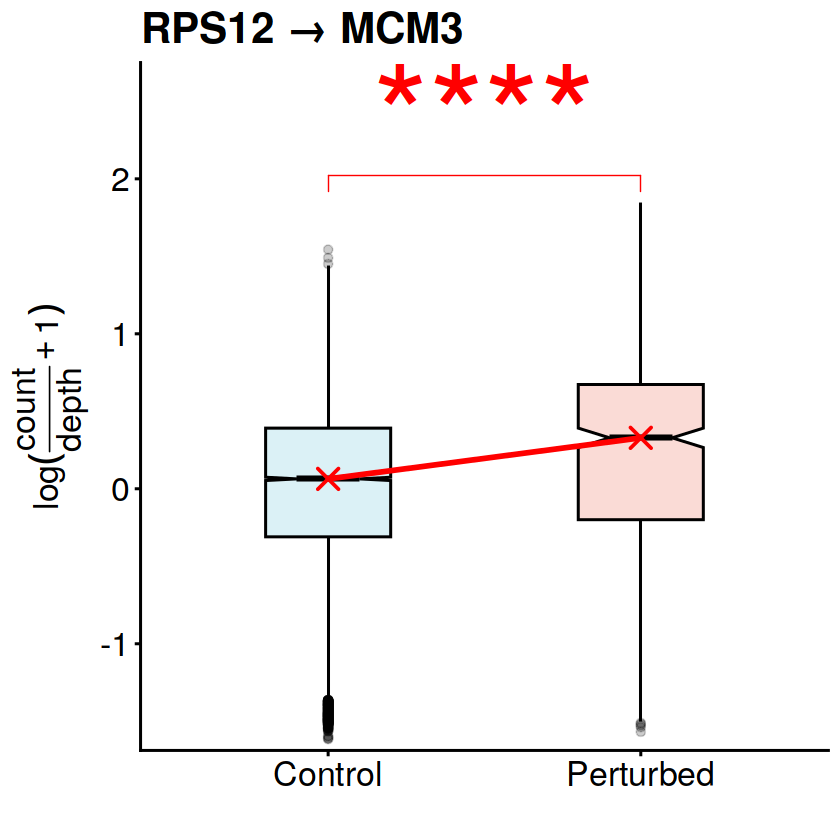

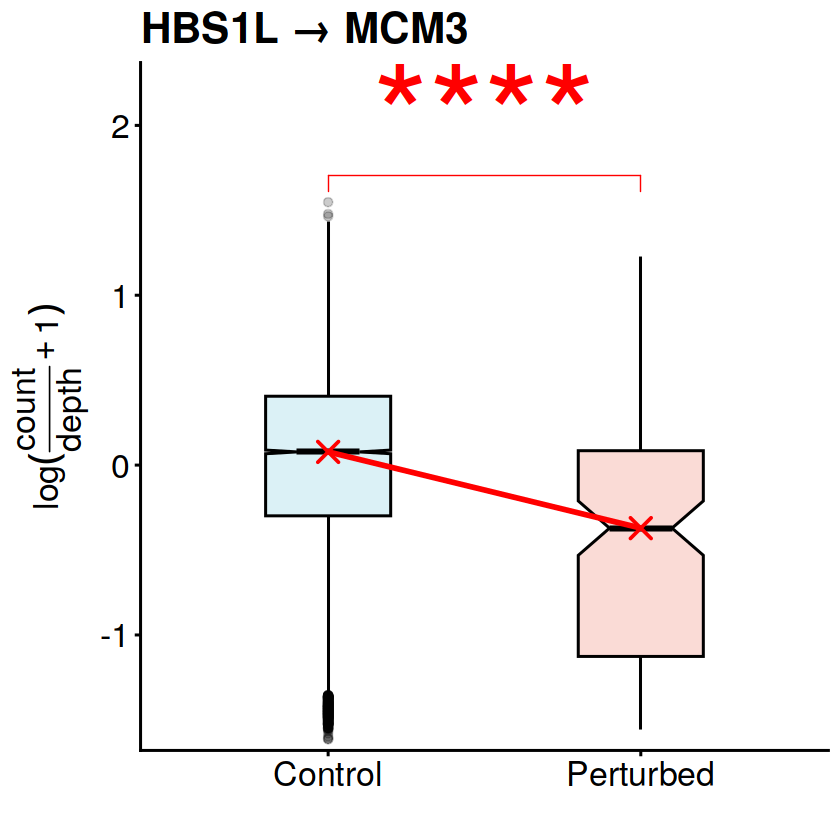

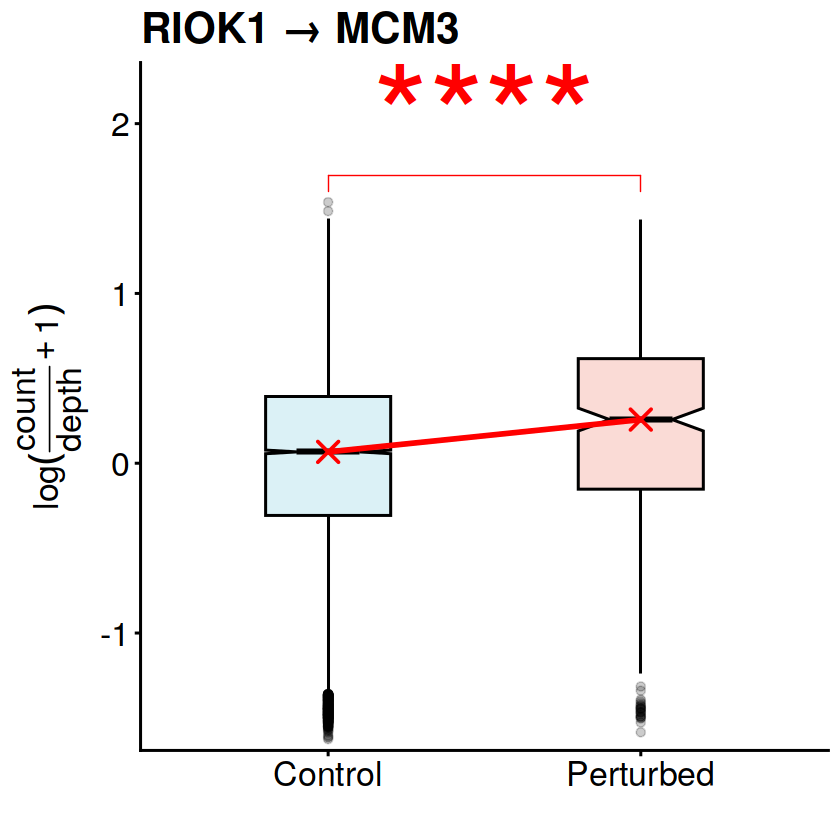

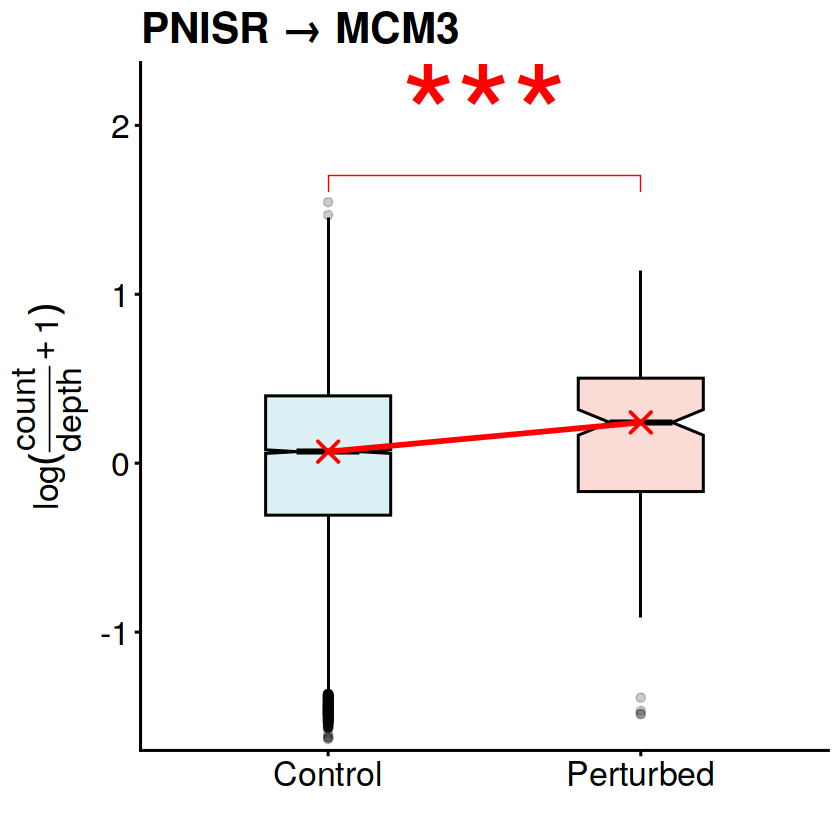

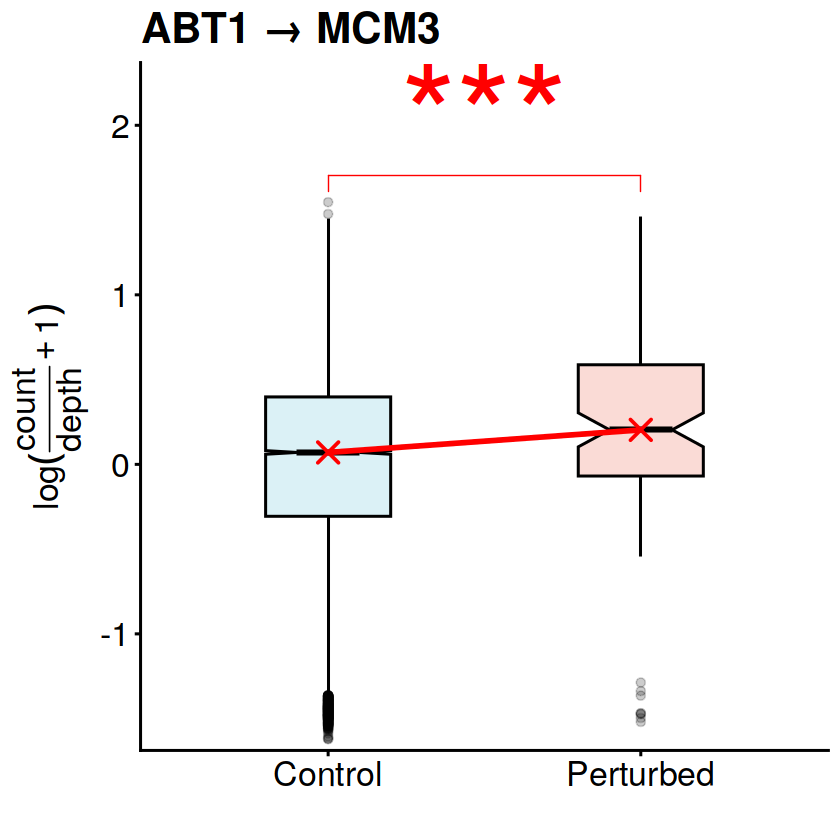

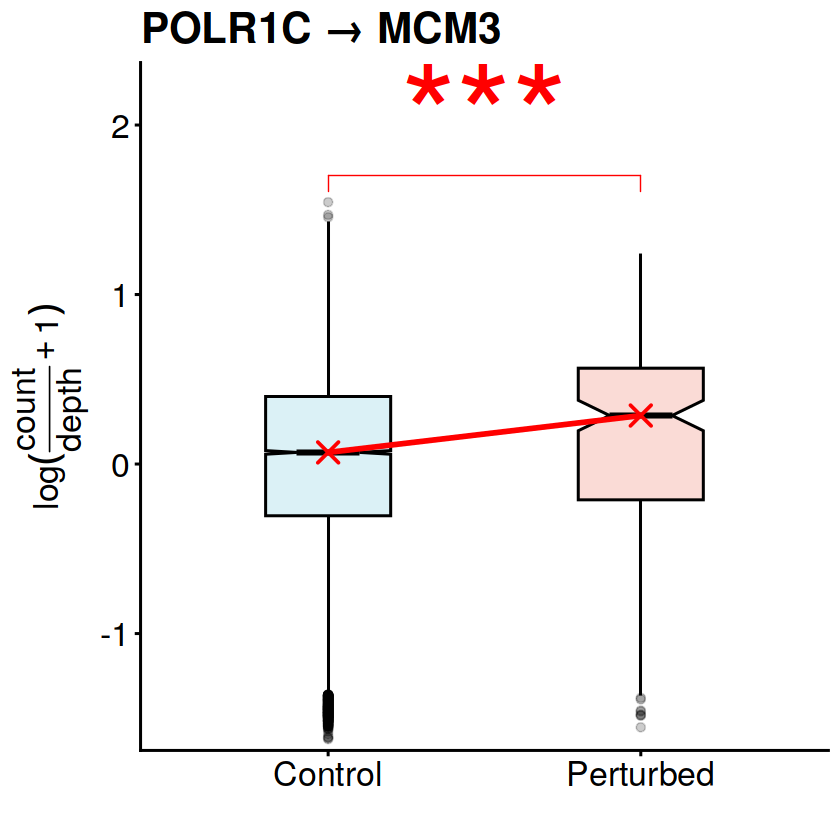

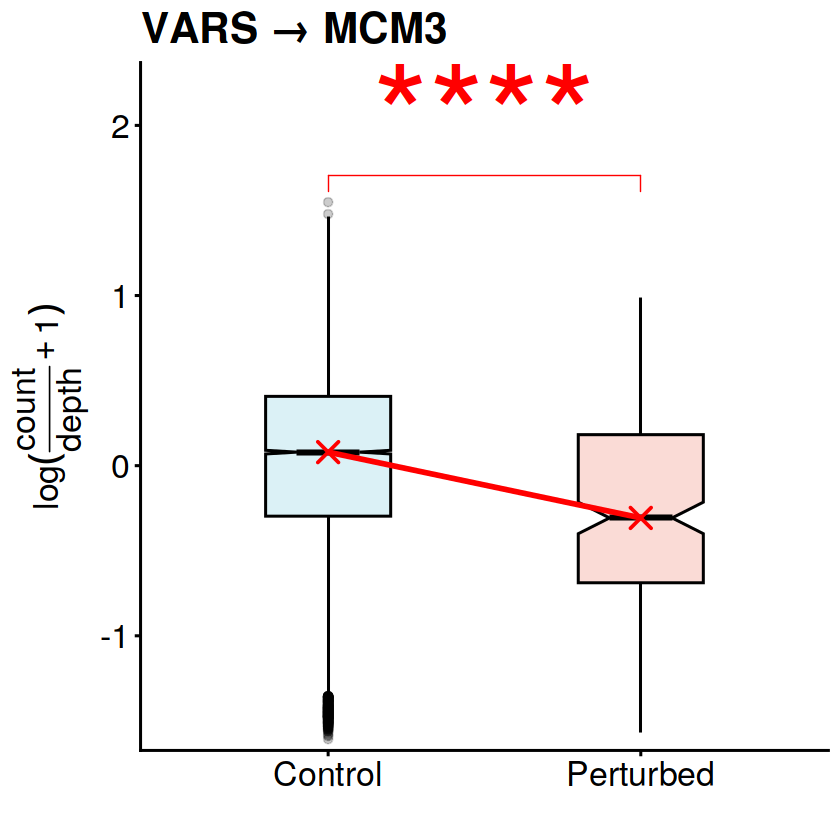

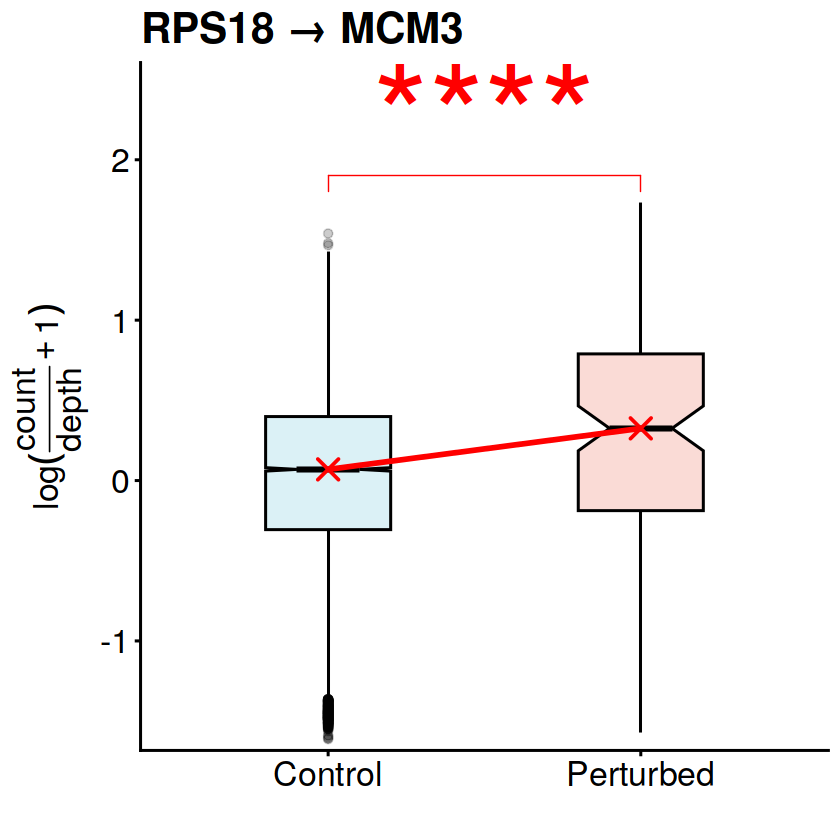

In [12]:
suppressPackageStartupMessages({
  library(ggpubr)  
})

df=edges_renamed %>% filter(to_gene=='MCM3')
cc_df=meta_data %>% as.data.frame

ctr_cells <-  meta_data[gene == "non-targeting"]$cell_barcode

for (fg in df$from_gene) {

  tg <-'MCM3'
  cc_df$gem_group <- as.factor(cc_df$gem_group)
  cc_cols = c('mitopercent', "gem_group")

  p_cells <- meta_data[gene == fg]$cell_barcode
  fg_id   <- unique(meta_data[gene == fg]$gene_id)
  tg_id   <- unique(meta_data[gene == tg]$gene_id)

  perturb_ind <- D[, fg_id] == 1
  # target expression in perturbed vs control
  x1 <- X_raw[perturb_ind, tg_id]
  x0 <- X_raw[control_ind,  tg_id]

  y     <- c(x1, x0)
  d     <- c(D[perturb_ind, fg_id], D[control_ind, fg_id])
  X     <- rbind(cc_df[perturb_ind, cc_cols], cc_df[control_ind, cc_cols])# %>% as.matrix()
  depth <- c(C[perturb_ind], C[control_ind])

  df_plot <- data.frame(
    y = y,
    depth = depth,
    d = factor(d, levels = c(0, 1), labels = c("Control", "Perturbed")),X=X
  )
  df_plot$yv <- log(df_plot$y / df_plot$depth + 1)
  df_plot$yv <- resid(lm(yv~X.mitopercent+X.gem_group,df_plot))

  # (optional) compute max y for headroom
  y_max  <- max(df_plot$yv, na.rm = TRUE)

  g <- ggplot(df_plot, aes(x = d, y = yv, fill = d)) +
    geom_boxplot(width = 0.4, color = "black", notch = TRUE, alpha = 0.2) +
    # X mark at each group median
    stat_summary(fun = median, geom = "point",
                 shape = 4, size = 5, stroke = 1.2, color = "red") +
    # line connecting medians
    stat_summary(aes(group = 1), fun = median, geom = "line",
                 linewidth = 1.2, color = "red") +
    # ---- ggpubr significance (Wilcoxon, one comparison) ----
    stat_compare_means(
      comparisons = list(c("Control", "Perturbed")),
      method = "wilcox.test",
      alternative = "greater",
      label = "p.signif",         # show stars; use "p.format" for formatted p
      hide.ns = TRUE,size=30,color='red'       # push bracket a bit above the boxes
    ) +
    scale_fill_manual(values = c("#4DBBD5", "#E64B35")) +
    labs(
      x = "",
      y = expression(log(frac(count, depth) + 1)),
      title = sprintf("%s → %s", fg, tg)
    ) +
    # add headroom so the bracket & label don't clip
    scale_y_continuous(expand = expansion(mult = c(0.02, 0.2))) +
    theme_classic(base_size = 14) +
    theme(
      legend.position = "none",
      axis.text = element_text(size = 20),
      axis.title = element_text(size = 20),
      plot.title = element_text(size = 25, face = "bold")
    )

  print(g)
}


### Intervention effect of MCM3 on the parent genes

The code below evaluates the intervention effect of perturbing MCM3 gene on the parent genes of MCM3. The resulting figures correspond to the panels shown in Fig. 3c of the manuscript.

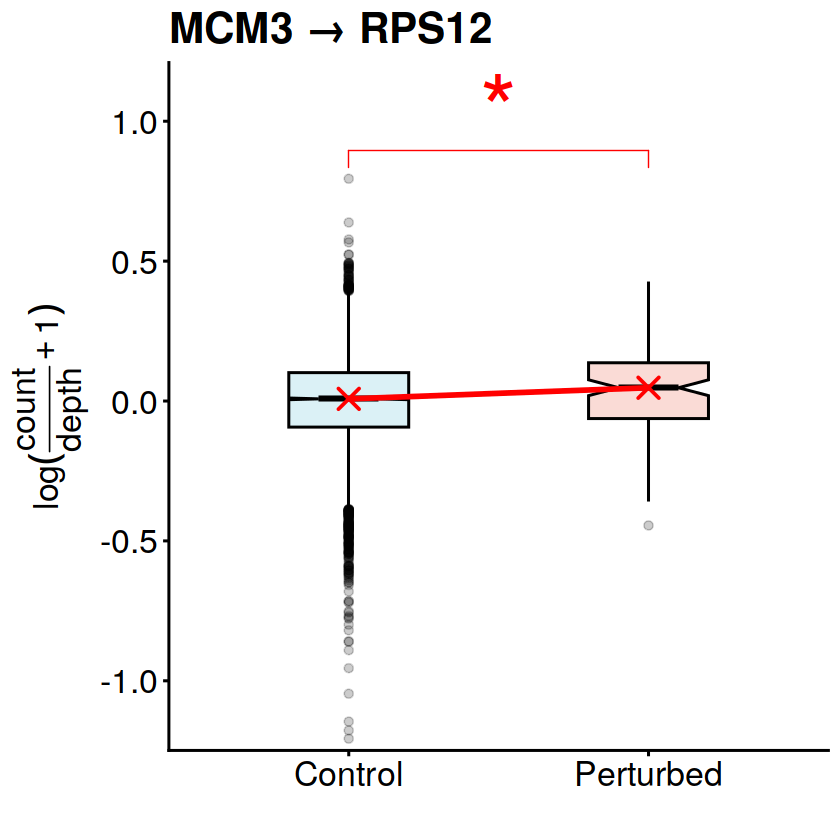

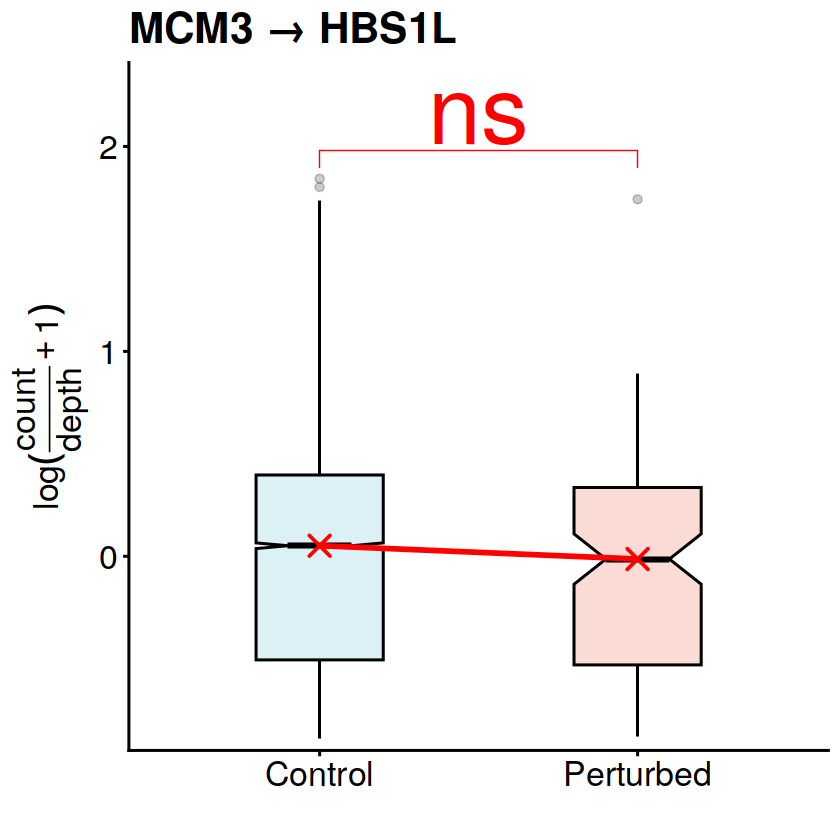

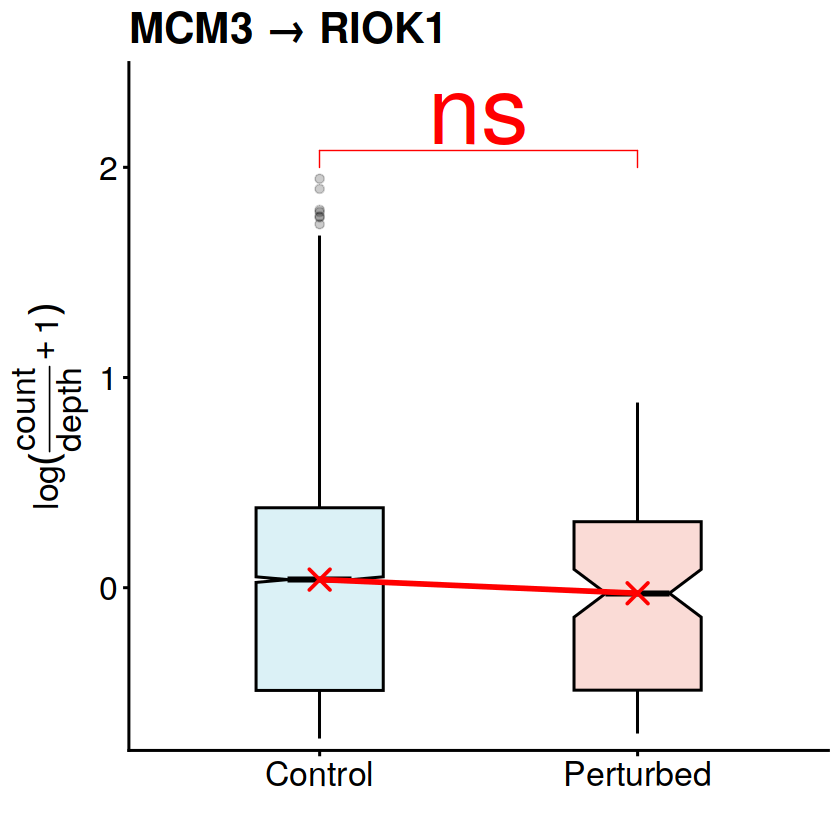

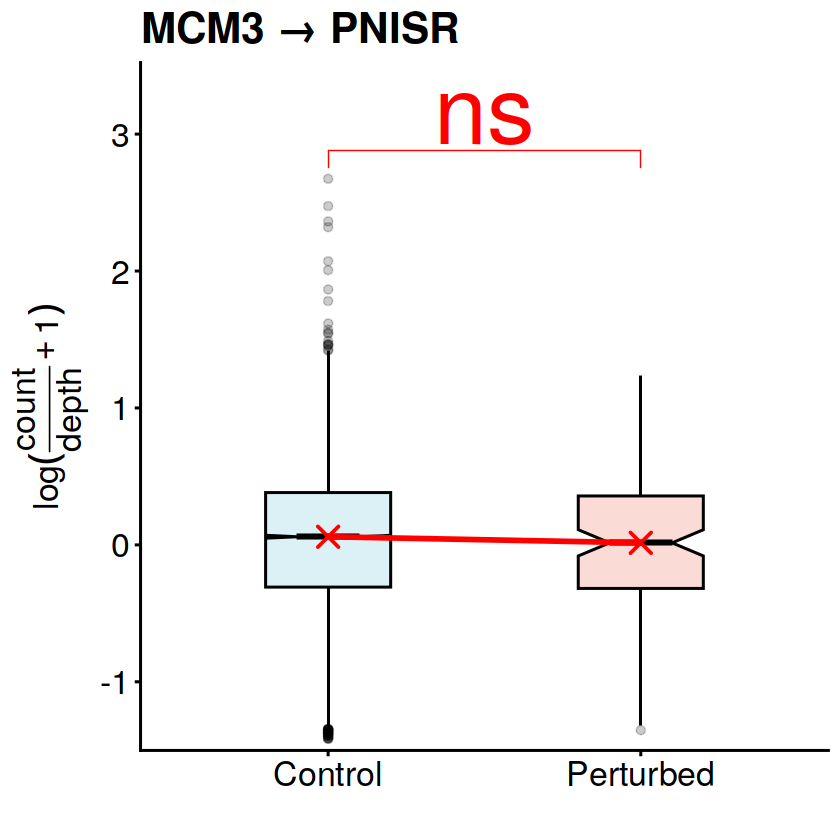

Notch went outside hinges
ℹ Do you want `notch = FALSE`?


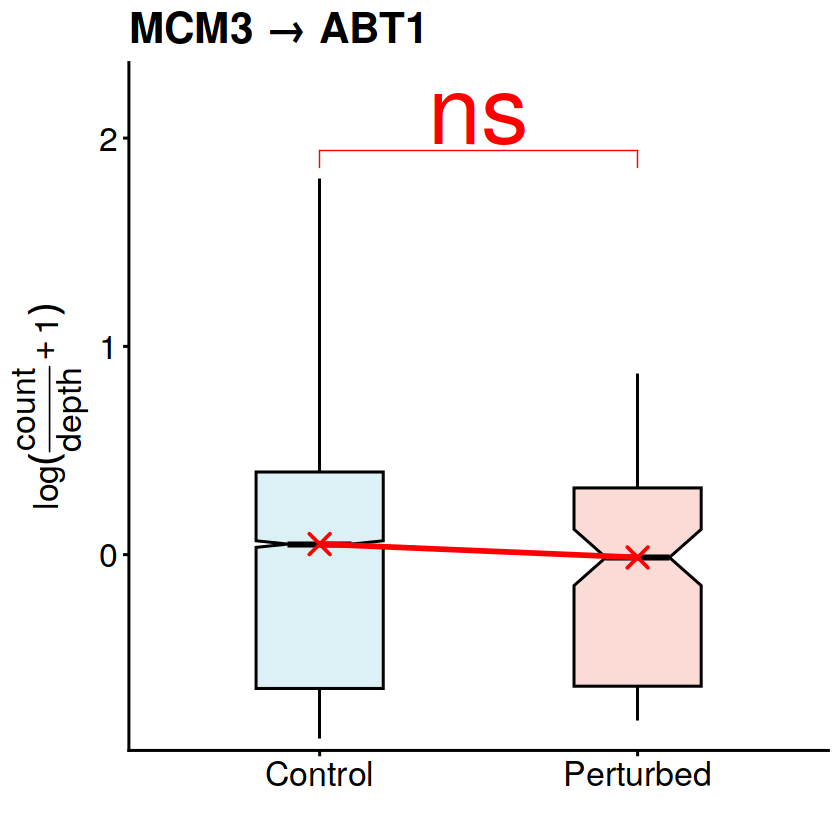

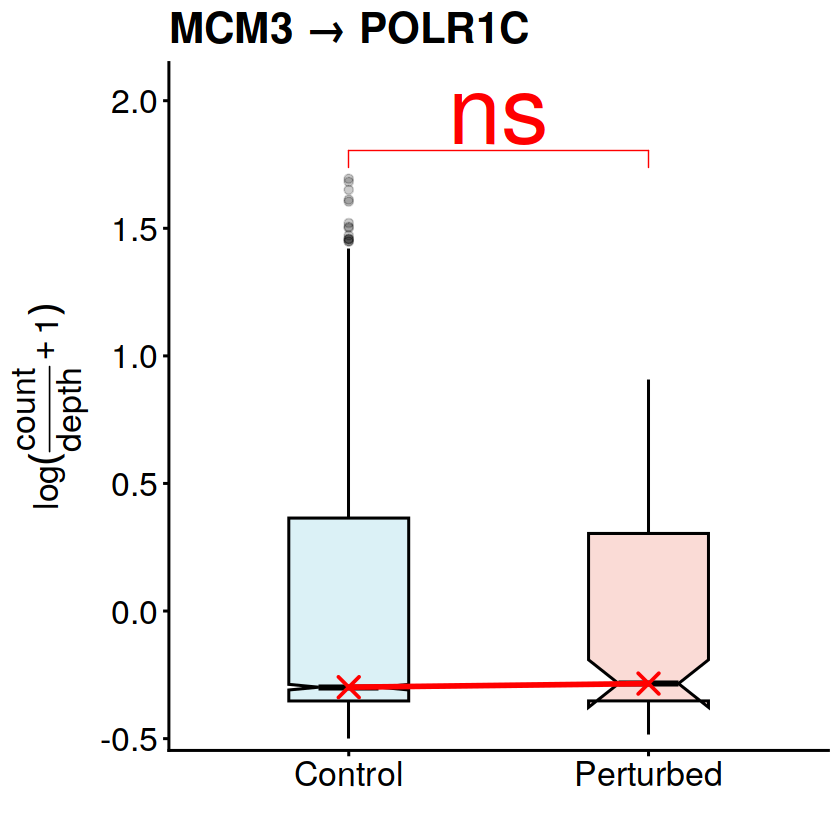

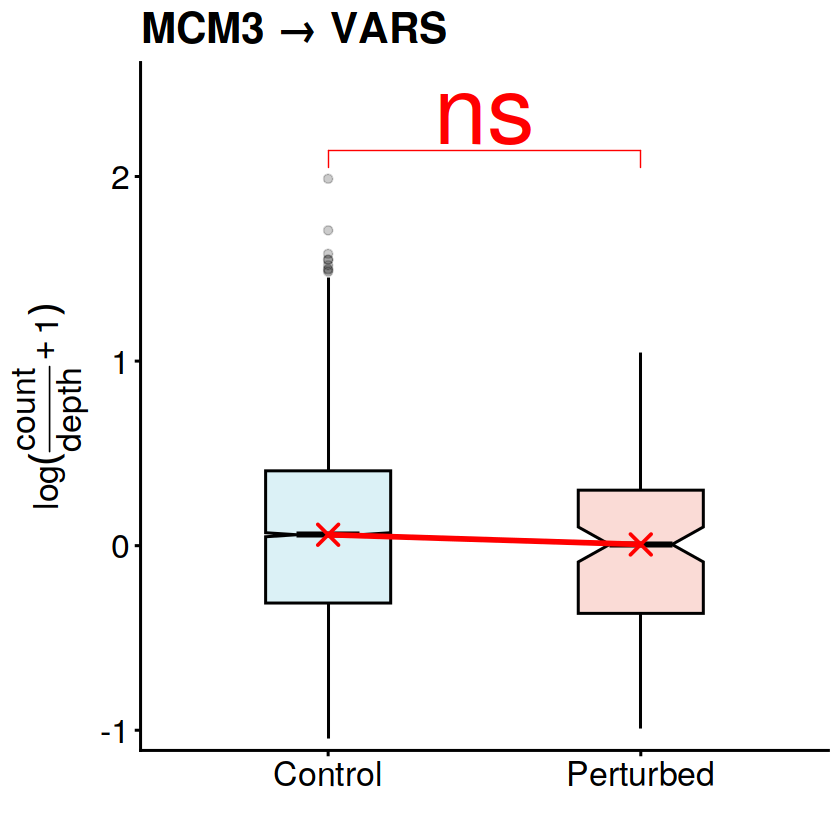

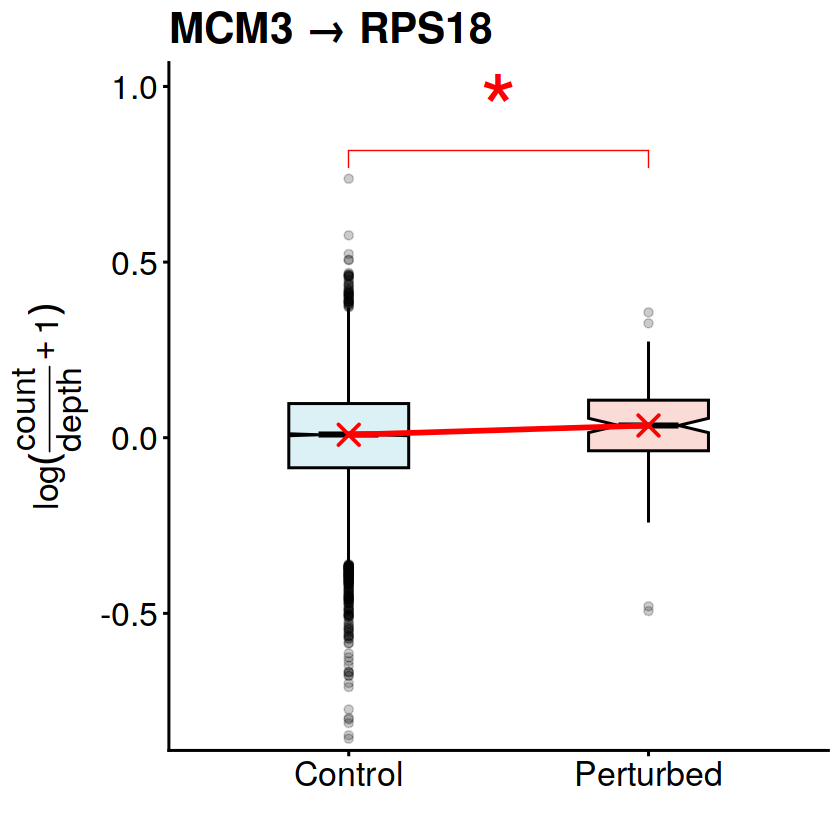

In [13]:
for (tg in df$from_gene) {

  fg <- 'MCM3'

  p_cells <- meta_data[gene == fg]$cell_barcode
  fg_id   <- unique(meta_data[gene == fg]$gene_id)
  tg_id   <- unique(meta_data[gene == tg]$gene_id)

  perturb_ind <- D[, fg_id] == 1
  # target expression in perturbed vs control
  x1 <- X_raw[perturb_ind, tg_id]
  x0 <- X_raw[control_ind,  tg_id]

  y     <- c(x1, x0)
  d     <- c(D[perturb_ind, fg_id], D[control_ind, fg_id])
  X     <- rbind(cc_df[perturb_ind, cc_cols], cc_df[control_ind, cc_cols]) #%>% as.matrix()
  depth <- c(C[perturb_ind], C[control_ind])

  df_plot <- data.frame(
    y = y,
    depth = depth,
    d = factor(d, levels = c(0, 1), labels = c("Control", "Perturbed")),
    X =X
  )
    
  df_plot$yv <- log(df_plot$y / df_plot$depth + 1)
  df_plot$yv <- resid(lm(yv~X.mitopercent+X.gem_group,df_plot))
  # (optional) compute max y for headroom
  y_max  <- max(df_plot$yv, na.rm = TRUE)

  g <- ggplot(df_plot, aes(x = d, y = yv, fill = d)) +
    geom_boxplot(width = 0.4, color = "black", notch = TRUE, alpha = 0.2) +
    # X mark at each group median
    stat_summary(fun = median, geom = "point",
                 shape = 4, size = 5, stroke = 1.2, color = "red") +
    # line connecting medians
    stat_summary(aes(group = 1), fun = median, geom = "line",
                 linewidth = 1.2, color = "red") +
    # ---- ggpubr significance (Wilcoxon, one comparison) ----
    stat_compare_means(
      comparisons = list(c("Control", "Perturbed")),
      method = "wilcox.test",
      alternative = "greater",
      label = "p.signif",         # show stars; use "p.format" for formatted p
      hide.ns = FALSE,size=20,color='red'       # push bracket a bit above the boxes
    ) +
    scale_fill_manual(values = c("#4DBBD5", "#E64B35")) +
    labs(
      x = "",
      y = expression(log(frac(count, depth) + 1)),
      title = sprintf("%s → %s", fg, tg)
    ) +
    # add headroom so the bracket & label don't clip
    scale_y_continuous(expand = expansion(mult = c(0.02, 0.15))) +
    theme_classic(base_size = 14) +
    theme(
      legend.position = "none",
      axis.text = element_text(size = 20),
      axis.title = element_text(size = 20),
      plot.title = element_text(size = 25, face = "bold")
    )

  print(g)
}
